---
# Introducing `NideconvFitter`

This notebook illustrates how to perform a deconvolution using `nideconv` and specific classes from this repository. First, we read the data in with `linescanning.dataset.Dataset`, which formats our functional data and onset timings the way nideconv likes it. Then I show some useful functions to select specific portions of a larger dataframe. Then, we perform the fitting and do some plotting

In [1]:
# imports
from linescanning import dataset, plotting, utils
import warnings
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

warnings.simplefilter('ignore')
project_dir     = "/mnt/d/FSL/shared/spinoza/projects"
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = True

Load in some data. You could substitute this with the example data provided with the repository. However, when I did the deconvolution on that data the results didn't look good enough for illustrative purposes. So I have a different dataset here: 3 runs of a Size-Response experiment in which our target pRF was bombarded with flickering stimuli of 5 different sizes.

In [2]:
# Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
ribbon      = [356,363]

run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file   = utils.get_file_from_substring("events.tsv", run_files)
func_file


['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-6_bold.mat']

Here we plop everything in `Dataset`, which will automatically format the functional data and onset timings for us

In [3]:
window = 19
order = 3

## window 5 TR poly 2
data_obj = dataset.Dataset(func_file,
                           deleted_first_timepoints=50,
                           deleted_last_timepoints=50,
                           window_size=window,
                           high_pass=True,
                           tsv_file=exp_file,
                           poly_order=order,
                           use_bids=True)

df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_func

vox 0      vox 1     vox 2     vox 3      vox 4  \
subject run t                                                             
003     3   0.000   -2.866334  14.083719 -1.988107  0.113690  16.808964   
            0.105   -2.731872   7.639611 -0.292766  1.844203  10.715782   
            0.210   -2.411413   2.589464  1.009679  2.919769   5.803490   
            0.315   -1.941967  -1.205993  1.959622  3.432035   1.961720   
            0.420   -1.360548  -3.886038  2.597535  3.472650  -0.919974   
...                       ...        ...       ...       ...        ...   
        6   450.975 -0.286067   4.427052 -2.499157  0.259376   0.144744   
            451.080 -1.031774   3.322995 -1.656252 -0.482357  -0.469404   
            451.185 -2.373224   1.269698 -0.215656 -1.039851  -1.542968   
            451.290 -4.434526  -1.893455  1.906681 -1.355344  -3.147411   
            451.395 -7.339799  -6.327063  4.794800 -1.371109  -5.354178   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     3   0.000    7.069802 -1.533657  4.556024 -3.016156  3.671980  ...   
            0.105    5.792725  0.035250  2.529812 -1.397520  2.390802  ...   
            0.210    4.708469  1.229584  0.930727 -0.235647  1.309419  ...   
            0.315    3.793085  2.084744 -0.280434  0.515652  0.412011  ...   
            0.420    3.022611  2.636099 -1.142937  0.902629 -0.317246  ...   
...                       ...       ...       ...       ...       ...  ...   
        6   450.975  0.236428  1.024055 -3.330529 -0.593460 -4.570794  ...   
            451.080  0.443566  0.784433 -4.168653 -0.104576 -4.802859  ...   
            451.185  0.664818  0.398982 -4.919606  0.328934 -4.763156  ...   
            451.290  0.887775 -0.153035 -5.559010  0.669765 -4.407734  ...   
            451.395  1.100028 -0.892341 -6.062537  0.880599 -3.692633  ...   

                       vox 710   vox 711   vox 712    vox 713    vox 714  \
subject run t                                                              
003     3   0.000    20.041609 -2.893972 -3.113472  28.284395  22.574759   
            0.105    13.123644 -2.338380 -3.603470  24.276043  25.938808   
            0.210     7.098806 -2.388048 -4.085654  20.256197  26.934469   
            0.315     1.935005 -2.933574 -4.515558  16.295683  25.942373   
            0.420    -2.399850 -3.865558 -4.848647  12.465286  23.343159   
...                        ...       ...       ...        ...        ...   
        6   450.975 -10.662567 -5.864281 -2.991349  -4.223704  -3.878438   
            451.080 -11.166388 -5.701602 -2.756113   2.298379  -2.733028   
            451.185  -9.856820 -4.813642 -1.388854  12.425220  -1.049483   
            451.290  -6.376439 -3.100652  1.357698  26.691866   1.228428   
            451.395  -0.367832 -0.462925  5.730820  45.633339   4.156923   

                       vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                               
003     3   0.000    11.838984   9.748781   9.124851 -28.957439  -0.681329  
            0.105     3.750193  13.243998  -2.194244 -40.782459  -2.693141  
            0.210    -2.432853  15.028024  -9.242016 -47.083084  -3.727466  
            0.315    -6.902874  15.394092 -12.620937 -48.653339  -3.936589  
            0.420    -9.852594  14.635431 -12.933511 -46.287239  -3.472793  
...                        ...        ...        ...        ...        ...  
        6   450.975  -0.715703  10.004318  -7.091761  -4.880929  10.010111  
            451.080  -0.509238  10.141683 -11.921310  -7.527745   9.141647  
            451.185   0.390518   9.073973 -19.830114  -9.304685   7.461154  
            451.290   2.087855   6.574023 -31.330925  -9.941059   4.834628  
            451.395   4.687083   2.414572 -46.936512  -9.166157   1.128042  

[13300 rows x 720 columns]

Now we have our data formatted the way `nideconv` likes it: the functional data is indexed by `subject`, `run`, and `t`, while the onset dataframe is indexed by `subject`, `run`, and `event_type`:

In [4]:
df_func.head()


vox 0      vox 1     vox 2     vox 3      vox 4  \
subject run t                                                           
003     3   0.000 -2.866334  14.083719 -1.988107  0.113690  16.808964   
            0.105 -2.731872   7.639611 -0.292766  1.844203  10.715782   
            0.210 -2.411413   2.589464  1.009679  2.919769   5.803490   
            0.315 -1.941967  -1.205993  1.959622  3.432035   1.961720   
            0.420 -1.360548  -3.886038  2.597535  3.472650  -0.919974   

                      vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                        ...   
003     3   0.000  7.069802 -1.533657  4.556024 -3.016156  3.671980  ...   
            0.105  5.792725  0.035250  2.529812 -1.397520  2.390802  ...   
            0.210  4.708469  1.229584  0.930727 -0.235647  1.309419  ...   
            0.315  3.793085  2.084744 -0.280434  0.515652  0.412011  ...   
            0.420  3.022611  2.636099 -1.142937  0.902629 -0.317246  ...   

                     vox 710   vox 711   vox 712    vox 713    vox 714  \
subject run t                                                            
003     3   0.000  20.041609 -2.893972 -3.113472  28.284395  22.574759   
            0.105  13.123644 -2.338380 -3.603470  24.276043  25.938808   
            0.210   7.098806 -2.388048 -4.085654  20.256197  26.934469   
            0.315   1.935005 -2.933574 -4.515558  16.295683  25.942373   
            0.420  -2.399850 -3.865558 -4.848647  12.465286  23.343159   

                     vox 715    vox 716    vox 717    vox 718   vox 719  
subject run t                                                            
003     3   0.000  11.838984   9.748781   9.124851 -28.957439 -0.681329  
            0.105   3.750193  13.243998  -2.194244 -40.782459 -2.693141  
            0.210  -2.432853  15.028024  -9.242016 -47.083084 -3.727466  
            0.315  -6.902874  15.394092 -12.620937 -48.653339 -3.936589  
            0.420  -9.852594  14.635431 -12.933511 -46.287239 -3.472793  

[5 rows x 720 columns]

In [5]:
df_onsets.head()

onset
subject run event_type                  
003     3   2.014613132977678  24.363776
            3.5652478065289    26.655493
            3.5652478065289    35.213706
            2.13914868391734   36.855363
            2.13914868391734   39.913720

Theoretically, `nideconv` should be able to concatenate multiple runs. Unfortunately, I haven't been able to get this to work yet, so what you can do instead is run the fitter for separate runs and then average the results. Alternatively, you can concatenate the runs yourself, but that becomes tricky with onset times (maybe I should implement such an option in `linescanning.dataset.Dataset`..). 

In any case, you can select portions of dataframes using `utils.select_from_df` given an expression. This expression is written in the form of how you say it. For instance: "_I want the data of subject 1 and run 1_", you'd specify: `utils.select_from_df(<dataframe>, expression=("subject = 1", "and", "run = 1"))`. The spaces in the expression are mandatory, as well as a separate operator in case you have multiple conditions. This is because, internally, the operator must be converted from string to operator-function. 

If your dataframe was indexed, you'll be returned a subset of the dataframe conform your expression with the same indexing.

In [6]:
# this is a bit simple because we only have 3 run in this dataset, but it illustrates the principle
utils.select_from_df(df_func, expression="run = 3")

vox 0      vox 1     vox 2     vox 3      vox 4  \
subject run t                                                             
003     3   0.000   -2.866334  14.083719 -1.988107  0.113690  16.808964   
            0.105   -2.731872   7.639611 -0.292766  1.844203  10.715782   
            0.210   -2.411413   2.589464  1.009679  2.919769   5.803490   
            0.315   -1.941967  -1.205993  1.959622  3.432035   1.961720   
            0.420   -1.360548  -3.886038  2.597535  3.472650  -0.919974   
...                       ...        ...       ...       ...        ...   
            450.975  2.323198  -2.522868  1.806688  4.131079   0.005221   
            451.080  0.935221  -2.879173  2.496827  3.340364   0.540626   
            451.185 -1.249576  -2.895468  2.913606  2.415967   1.310349   
            451.290 -4.338670  -2.504259  2.987731  1.377296   2.348626   
            451.395 -8.439552  -1.638043  2.649927  0.243783   3.689718   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     3   0.000    7.069802 -1.533657  4.556024 -3.016156  3.671980  ...   
            0.105    5.792725  0.035250  2.529812 -1.397520  2.390802  ...   
            0.210    4.708469  1.229584  0.930727 -0.235647  1.309419  ...   
            0.315    3.793085  2.084744 -0.280434  0.515652  0.412011  ...   
            0.420    3.022611  2.636099 -1.142937  0.902629 -0.317246  ...   
...                       ...       ...       ...       ...       ...  ...   
            450.975 -0.562251 -0.651824 -0.971246 -2.376860 -1.549292  ...   
            451.080 -0.700343 -0.733382  0.328851 -2.575815 -0.919849  ...   
            451.185 -0.665623 -0.726724  1.924944 -2.728111 -0.012267  ...   
            451.290 -0.408691 -0.617766  3.833735 -2.815366  1.206326  ...   
            451.395  0.119865 -0.392431  6.071937 -2.819240  2.768791  ...   

                       vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                                
003     3   0.000    20.041609  -2.893972  -3.113472  28.284395  22.574759   
            0.105    13.123644  -2.338380  -3.603470  24.276043  25.938808   
            0.210     7.098806  -2.388048  -4.085654  20.256197  26.934469   
            0.315     1.935005  -2.933574  -4.515558  16.295683  25.942373   
            0.420    -2.399850  -3.865558  -4.848647  12.465286  23.343159   
...                        ...        ...        ...        ...        ...   
            450.975   1.367223  16.892731   4.745126 -18.685102 -19.655090   
            451.080   0.280285  20.415449   5.693340 -19.252127 -20.495415   
            451.185  -0.849497  24.626350   7.947314 -17.688549 -19.808828   
            451.290  -1.994359  29.576921  11.773038 -13.562769 -17.259884   
            451.395  -3.126514  35.318661  17.436504  -6.443191 -12.513166   

                       vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                               
003     3   0.000    11.838984   9.748781   9.124851 -28.957439  -0.681329  
            0.105     3.750193  13.243998  -2.194244 -40.782459  -2.693141  
            0.210    -2.432853  15.028024  -9.242016 -47.083084  -3.727466  
            0.315    -6.902874  15.394092 -12.620937 -48.653339  -3.936589  
            0.420    -9.852594  14.635431 -12.933511 -46.287239  -3.472793  
...                        ...        ...        ...        ...        ...  
            450.975  -3.898853  -2.823085   0.432134  -4.101414   4.093790  
            451.080  -9.931654   0.878227   1.090717  -2.618438   7.467568  
            451.185 -16.845613   6.935096   1.600945  -2.050191  12.343979  
            451.290 -24.668688  15.708661   1.935065  -2.645785  18.992222  
            451.395 -33.428848  27.560032   2.065289  -4.654318  27.681494  

[4300 rows x 720

We can also select only the voxels from the GM-ribbon. For convenience, we'll continue with this subset of the dataframe for our fitting

In [7]:
df_ribbon = utils.select_from_df(df_func, expression='ribbon', indices=ribbon)
df_ribbon


vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run t                                                           
003     3   0.000   -1.358449 -1.250654 -0.844562 -3.141600 -3.653800   
            0.105   -0.361371 -0.744641 -0.197726 -2.225953 -2.785009   
            0.210    0.394225 -0.284255  0.330091 -1.493466 -2.035612   
            0.315    0.934887  0.129068  0.748312 -0.922799 -1.396024   
            0.420    1.287174  0.493908  1.066327 -0.492632 -0.856662   
...                       ...       ...       ...       ...       ...   
        6   450.975  1.598001  1.222181  1.771379  1.609623  1.477003   
            451.080  1.387107  0.908804  1.592183  1.420629  1.420915   
            451.185  1.024914  0.448728  1.281309  1.103938  1.304400   
            451.290  0.487196 -0.175989  0.818789  0.640738  1.120031   
            451.395 -0.250280 -0.983244  0.184584  0.012219  0.860417   

                      vox 361   vox 362  
subject run t                            
003     3   0.000   -5.446231 -2.971393  
            0.105   -3.802073 -2.257657  
            0.210   -2.494007 -1.613081  
            0.315   -1.483655 -1.035947  
            0.420   -0.732601 -0.524586  
...                       ...       ...  
        6   450.975  1.391435  0.924611  
            451.080  1.274931  0.804341  
            451.185  1.095700  0.658345  
            451.290  0.845397  0.486505  
            451.395  0.515676  0.288737  

[13300 rows x 7 columns]

In [8]:
# this also works for onset dataframes
utils.select_from_df(df_onsets, expression="run = 3")

onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     26.655493
            3.5652478065289     35.213706
            2.13914868391734    36.855363
            2.13914868391734    39.913720
...                                   ...
            2.13914868391734   372.703811
            2.13914868391734   376.503695
            2.13914868391734   386.603704
            2.13914868391734   388.230752
            2.13914868391734   392.345201

[78 rows x 1 columns]

Right, on to the fitting: we can do the fitting with `utils.NideconvFitter`, which requires the functional dataframe, onset dataframe, and some settings on the type of fit you'd like to do, number of regressors, confounds, etc

In [102]:
nd_fit = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              confounds=None,
                              basis_sets='fourier',
                              n_regressors=19,
                              lump_events=False,
                              TR=0.105,
                              interval=[0,12],
                              add_intercept=True,
                              verbose=True)

Selected 'fourier'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


With `plot_average_per_event`, we can plot the average response across the voxels in the dataframe for each event in the model:

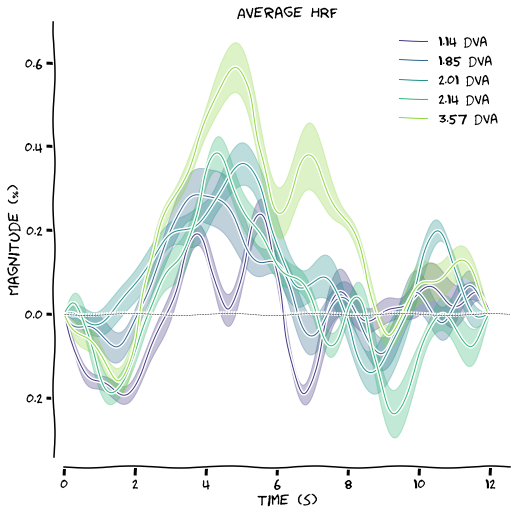

In [90]:
nd_fit.plot_average_per_event(xkcd=plot_xkcd, 
                              labels=[f"{round(float(ii),2)} dva" for ii in nd_fit.cond], 
                              alpha=0.2, 
                              figsize=(8,8), 
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              add_hline='default')


.. note:: Using `**kwargs`, we can specify any argument that `plotting.LazyPlot` accepts. This means we can specify any argument in any of the plotting functions contained in the class

We can also plot all events for individual voxel in the dataframe (mind you, if you have 720 voxels, you'll get that many plots. That's a bit of an overkill):

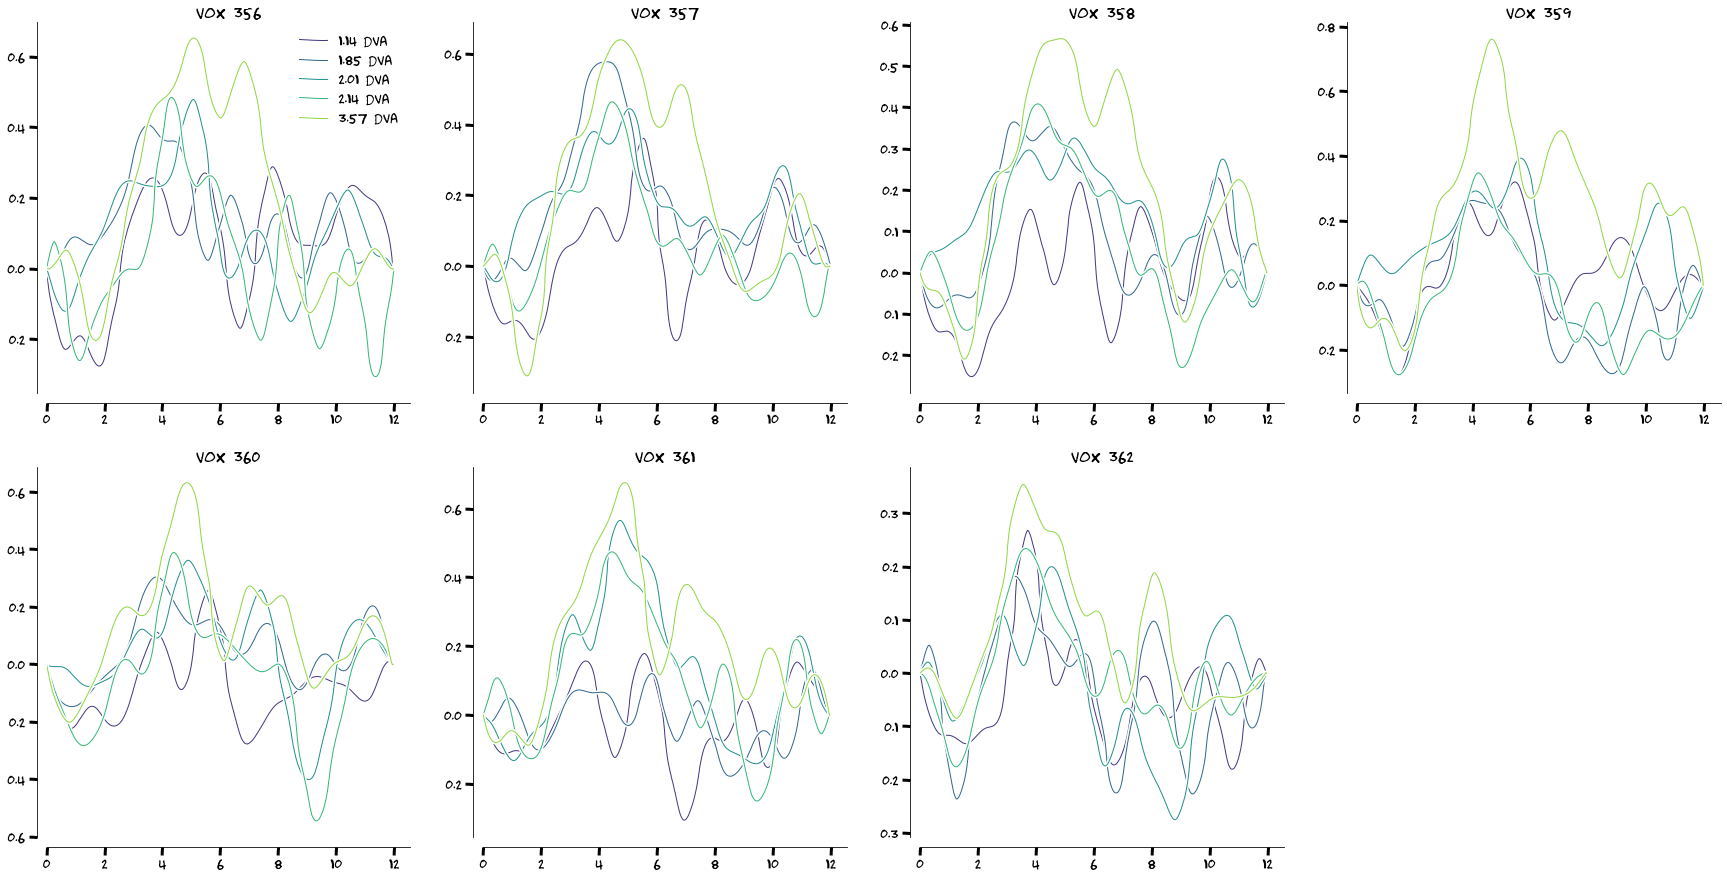

In [91]:
nd_fit.plot_average_per_voxel(xkcd=plot_xkcd, 
                              labels=[f"{round(float(ii),2)} dva" for ii in nd_fit.cond], 
                              wspace=0.2)


Above, we defined each stimulus size as separate event. To investigate a global response, we can also lump all the events together using `lump_events=True`. This means we'll interpret *any* event as 1 event:

In [101]:
lumped = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              confounds=None,
                              basis_sets='fourier',
                              n_regressors=19,
                              lump_events=True,
                              TR=0.105,
                              interval=[0,12],
                              add_intercept=True,
                              verbose=True)

Selected 'fourier'-basis sets
Adding event 'stim' to model
Fitting with 'ols' minimization
Done


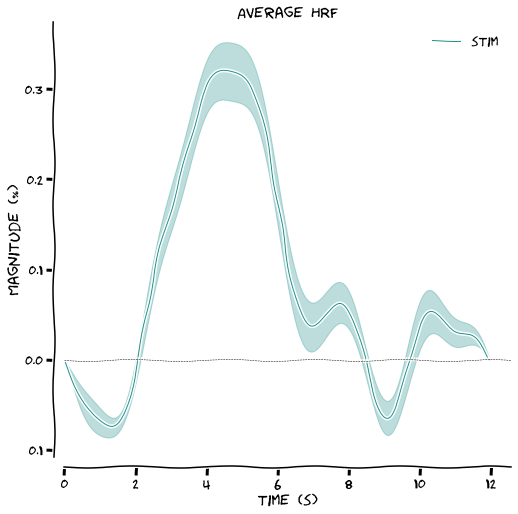

In [92]:
# plot average across voxels
lumped.plot_average_per_event(xkcd=plot_xkcd, 
                              labels=['stim'],
                              figsize=(8,8),
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              add_hline='default')


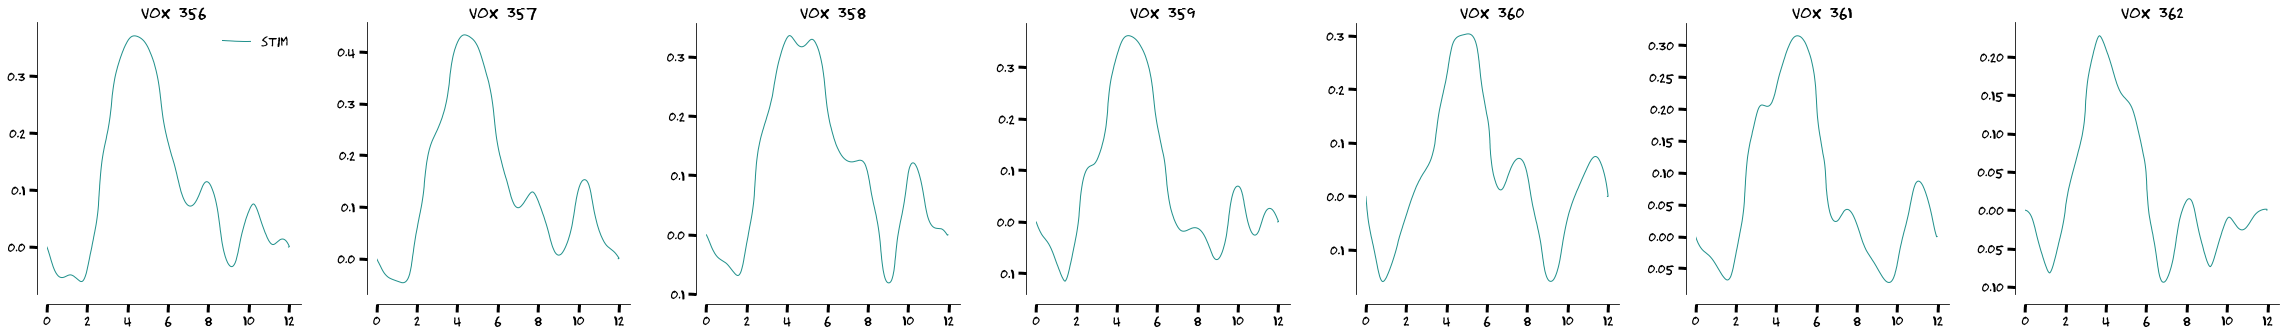

In [93]:
# plot individual voxels in separete figures
lumped.plot_average_per_voxel(xkcd=plot_xkcd, 
                              labels=['stim'], 
                              n_cols=7, 
                              figsize=(40,5),
                              wspace=0.3)

With this lumped-event model, we can also plot the HRFs across depth, independent of stimulus size (left plot). We can then extract the maximums of all HRFs and fit a polynomial to it, revealing a trend towards decreased HRF-amplitude when going from CSF/GM to GM/WM borders

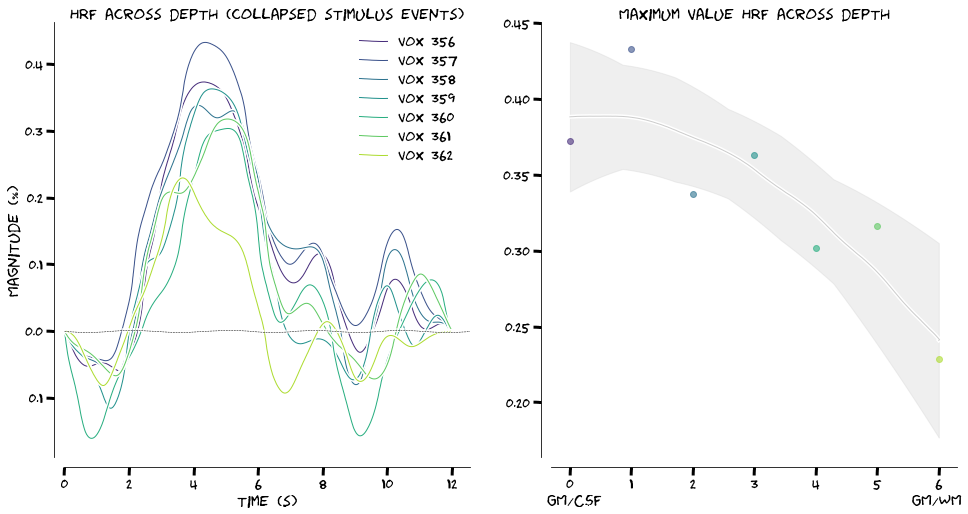

In [99]:
# plot individual voxels in 1 figure
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0])
lumped.plot_average_per_voxel(xkcd=plot_xkcd, 
                              n_cols=None, 
                              figsize=(8,8), 
                              axs=ax, 
                              labels=True,
                              title="HRF across depth (collapsed stimulus events)",
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              add_hline='default')

ax = fig.add_subplot(gs[1])
lumped.plot_hrf_across_depth(xkcd=True, 
                             axs=ax, 
                             title="Maximum value HRF across depth",
                             x_label="GM/CSF                                        GM/WM",
                             set_xlim_zero=False)
